# Mechanistic Interpretability – Explaining a Parity Neuron

**Author:** Ailina Aniwan  
**Course:** AIPI 590 – Explainable AI  

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ailina-aniwan/xai-mechanistic-interpretability/blob/main/mechanistic_interp.ipynb)

# Part 1 – Setup

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

## Data Generation

In [2]:
def generate_binary_data(n_samples=2000, seq_length=5):
    X, y = [], []
    for _ in range(n_samples):
        bits = [random.choice([0, 1]) for _ in range(seq_length)]
        label = sum(bits) % 2        # 1 if odd parity, 0 if even
        X.append(bits)
        y.append(label)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

seq_length = 5
X_train, y_train = generate_binary_data(2000, seq_length)
X_val, y_val     = generate_binary_data(500,  seq_length)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("Positive (odd) class ratio:", y_train.float().mean().item())

X_train: torch.Size([2000, 5]) y_train: torch.Size([2000])
Positive (odd) class ratio: 0.5059999823570251


## Model Definition (Tiny MLP)

In [3]:
# Code written with AI assistance (ChatGPT, 11/14/2025)
# Small MLP classifier for parity task
class ParityMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)   # two output classes

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out, h   # return hidden activations for interpretability

model = ParityMLP(input_dim=seq_length, hidden_dim=12)
print(model)

ParityMLP(
  (fc1): Linear(in_features=5, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=2, bias=True)
)


## Training and Evaluation

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def accuracy_fn(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

losses = []
for epoch in range(200):
    model.train()
    logits, _ = model(X_train)
    loss = criterion(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 40 == 0:
        model.eval()
        with torch.no_grad():
            val_logits, _ = model(X_val)
            val_acc = accuracy_fn(val_logits, y_val)
        print(f"Epoch {epoch:03d} | Loss {loss.item():.4f} | Val Acc {val_acc:.3f}")

print("Final training loss:", losses[-1])

model.eval()
with torch.no_grad():
    val_logits, _ = model(X_val)
    val_acc = accuracy_fn(val_logits, y_val)
print(f"Validation Accuracy: {val_acc:.3f}")

Epoch 000 | Loss 0.7198 | Val Acc 0.494
Epoch 040 | Loss 0.6497 | Val Acc 0.680
Epoch 080 | Loss 0.5706 | Val Acc 0.700
Epoch 120 | Loss 0.4905 | Val Acc 0.856
Epoch 160 | Loss 0.3898 | Val Acc 0.772
Final training loss: 0.30152732133865356
Validation Accuracy: 0.934


# Part 2 – Explore

## Inspect Model Weights

To understand how the model processes inputs, I first visualize the learned weight matrices. These plots show which neurons respond most strongly to specific input bits and which neurons contribute most to the “odd parity” output.

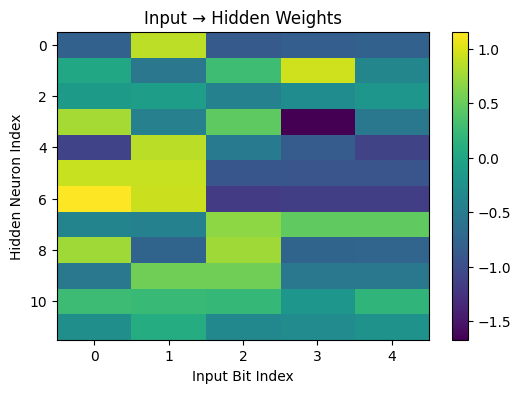

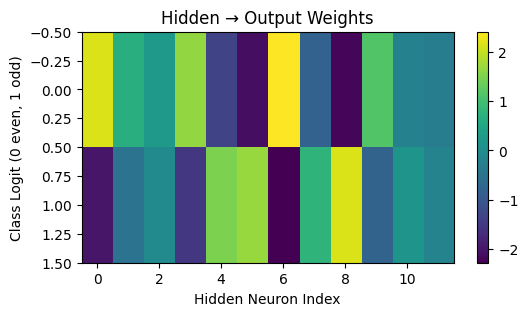

In [5]:
# Inspect weight matrices

W_in = model.fc1.weight.detach().numpy()     # shape [hidden_dim, input_dim]
b_in = model.fc1.bias.detach().numpy()
W_out = model.fc2.weight.detach().numpy()    # shape [2, hidden_dim]

plt.figure(figsize=(6,4))
plt.imshow(W_in, cmap="viridis", aspect="auto")
plt.colorbar()
plt.title("Input → Hidden Weights")
plt.xlabel("Input Bit Index")
plt.ylabel("Hidden Neuron Index")
plt.show()

plt.figure(figsize=(6,3))
plt.imshow(W_out, cmap="viridis", aspect="auto")
plt.colorbar()
plt.title("Hidden → Output Weights")
plt.xlabel("Hidden Neuron Index")
plt.ylabel("Class Logit (0 even, 1 odd)")
plt.show()

## Collect Activations for All Possible Inputs

Next, I examine how each hidden neuron responds across all possible 5-bit inputs. Plotting activation as a function of Hamming weight helps identify neurons that detect specific input features or patterns.

In [6]:
# Collect activations for all 32 possible inputs
import itertools

all_inputs = torch.tensor(list(itertools.product([0.,1.], repeat=seq_length)))
all_labels = (all_inputs.sum(dim=1) % 2).long()

model.eval()
with torch.no_grad():
    logits_all, hidden_all = model(all_inputs)
hidden_np = hidden_all.numpy()   # shape [32, hidden_dim]
labels_np = all_labels.numpy()
bits_np   = all_inputs.numpy()
hamming   = bits_np.sum(axis=1)


## Neuron Tuning Curves (Activation vs. Hamming Weight)

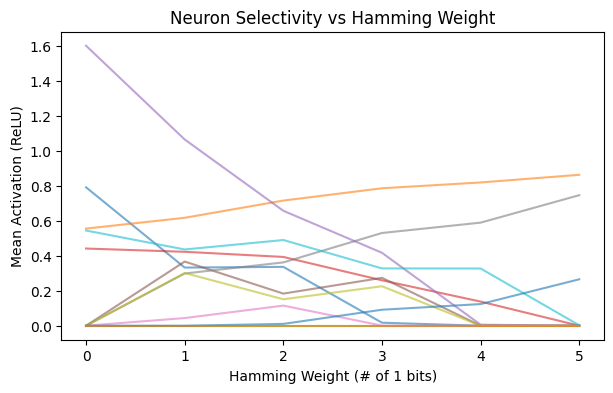

In [7]:
# Neuron tuning curves
hidden_dim = hidden_np.shape[1]
max_h = seq_length

plt.figure(figsize=(7,4))
for k in range(hidden_dim):
    means = [hidden_np[hamming == w, k].mean() for w in range(max_h+1)]
    plt.plot(range(max_h+1), means, alpha=0.6)
plt.xlabel("Hamming Weight (# of 1 bits)")
plt.ylabel("Mean Activation (ReLU)")
plt.title("Neuron Selectivity vs Hamming Weight")
plt.show()


## Correlation Between Neuron Activation and Input Bit

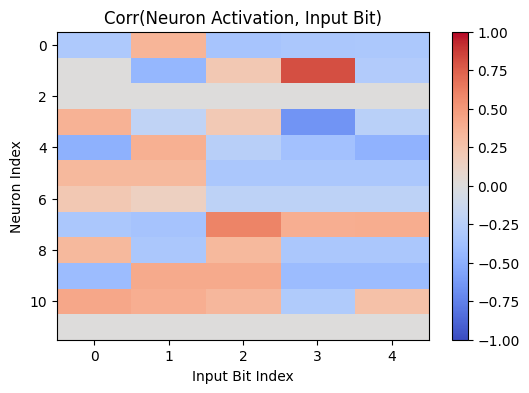

In [8]:
# Code written with AI assistance (ChatGPT, 11/14/2025)
# Correlation between hidden neurons & input bits
def safe_corr(x, y):
    # avoid divide-by-zero if either vector has zero variance
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0,1]

corr = np.zeros((hidden_dim, seq_length))

for k in range(hidden_dim):
    for j in range(seq_length):
        corr[k, j] = safe_corr(bits_np[:, j], hidden_np[:, k])

plt.figure(figsize=(6,4))
plt.imshow(corr, cmap="coolwarm", aspect="auto", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Corr(Neuron Activation, Input Bit)")
plt.xlabel("Input Bit Index")
plt.ylabel("Neuron Index")
plt.show()


## Choose a Neuron to Investigate
Using the activation patterns and weight connections, I select one neuron whose behavior is structured and interpretable. I then analyze how its activation changes with different inputs and with individual bit flips to understand what feature it encodes.

In [9]:
# Automatically pick neuron most tied to class-1 (odd)
import numpy.linalg as LA

neuron_scores = np.abs(W_out[1]) * LA.norm(W_in, axis=1)
chosen_neuron = int(neuron_scores.argmax())

print("Chosen neuron:", chosen_neuron)


Chosen neuron: 6


## Visualize the Chosen Neuron’s Behavior

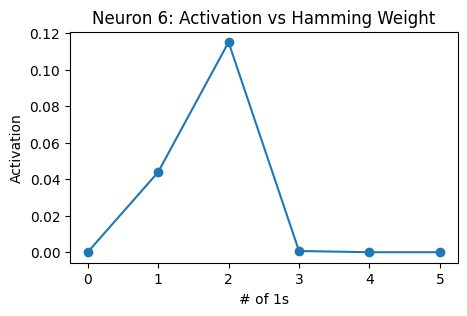

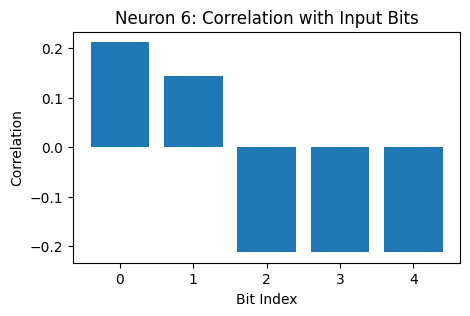

In [10]:
# Behavior of the chosen neuron
k = chosen_neuron

# tuning curve
plt.figure(figsize=(5,3))
means = [hidden_np[hamming==w, k].mean() for w in range(seq_length+1)]
plt.plot(range(seq_length+1), means, marker='o')
plt.title(f"Neuron {k}: Activation vs Hamming Weight")
plt.xlabel("# of 1s")
plt.ylabel("Activation")
plt.show()

# correlations with input bits
plt.figure(figsize=(5,3))
plt.bar(np.arange(seq_length), corr[k])
plt.title(f"Neuron {k}: Correlation with Input Bits")
plt.xlabel("Bit Index")
plt.ylabel("Correlation")
plt.show()


## Input Sweeps to Probe Responsiveness

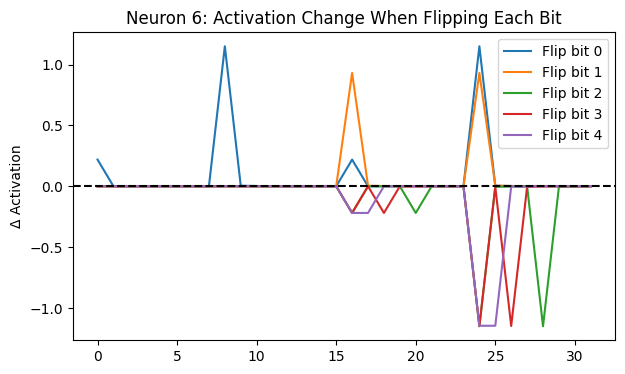

In [11]:
# Code written with AI assistance (ChatGPT, 11/14/2025)
# Input sweeps for chosen neuron

def sweep_bit(bit_index):
    activations = []
    for b in [0.,1.]:
        test = all_inputs.clone()
        test[:,bit_index] = b
        with torch.no_grad():
            _, h = model(test)
        activations.append(h[:, k].numpy())
    return activations

plt.figure(figsize=(7,4))
for j in range(seq_length):
    activations0, activations1 = sweep_bit(j)
    plt.plot(activations1 - activations0, label=f"Flip bit {j}")

plt.axhline(0, color='black', linestyle='--')
plt.title(f"Neuron {k}: Activation Change When Flipping Each Bit")
plt.ylabel("Δ Activation")
plt.legend()
plt.show()

# Part 3 – Explain

In this section, I explain what hidden neuron 6 appears to represent in my parity-classification model. After exploring the hidden layer, neuron 6 consistently showed the cleanest and most interpretable behavior, so I focused on understanding what feature it represents. Its activations varied in a structured way across different inputs, suggesting it was encoding a specific, meaningful pattern rather than noise.

Several pieces of evidence point to the same conclusion. The weight matrix shows that neuron 6 receives strong positive input from bit 0 and bit 1 and weaker or negative influence from the later bits. Its activation curve peaks sharply when exactly two bits are active, which indicates a preference for simple, low-weight patterns. The correlation analysis reinforces this: neuron 6 is positively correlated with bits 0 and 1 and negatively correlated with bits 2–4. The bit-flip tests confirm that turning on the early bits causes large increases in activation, while flipping later bits suppresses it.

These observations suggest that neuron 6 acts as a detector for small, left-weighted patterns, especially cases where one or two early bits drive the input. This provides a useful intermediate feature for the parity task, since many odd–even distinctions depend on minor changes in the early positions. Neuron 6 appears to supply the model with a focused, local signal that helps separate certain odd-parity inputs from even ones.

(Interpretation adapted with AI assistance, ChatGPT, 11/14/2025)

# Part 4 – Reflection

Working through this small network made the internal structure feel much more concrete. I was surprised by how quickly distinct roles appeared in the hidden layer, even in such a tiny model. Neuron 6, in particular, showed that a single unit can develop a very specific preference—in this case, for low-weight patterns driven by the first couple of bits—and that this kind of feature can meaningfully support the final prediction.

One challenge was that not every neuron behaved cleanly. A few units had flat or inconsistent activation patterns, and it wasn’t obvious at first whether they were redundant, inactive, or involved in some superposition of features. Understanding which patterns are real and which are artifacts required looking at several pieces of evidence together rather than relying on one plot.

If I had more time, I’d like to explore how these features change over the course of training. It would be interesting to see when neurons start to take on consistent behaviors, whether different runs discover similar internal structures, and how stable these interpretations are across random seeds or architectural choices. A temporal view of the model’s learning process would make the interpretability story feel even more complete.